In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR, LATEX_OUT

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd

import os
import time

from copy import deepcopy

from filterpy.kalman import KalmanFilter
from filterpy.common import Saver

from src.plotting import plot_dfs
from src.process_data import load_data
from src.utils import get_most_recent_mod_output, solve_updated_mod

from config import plt_config
plt.rcParams.update(plt_config)
# plt.rcParams.update({'font.size': 4})

load & solve model

In [ ]:
# mods = {
    # 'mod4_rbc_vanilla': {'params': mod4_params,
    #                      'priors': mod4_priors,
    #                      'plot_vars': ['A', 'Y', 'C', 'I', 'L', 'K', 'w', 'r', 'lambda'],
    #                      'is_lin': False},
#     'mod5_nk_vanilla': {'params': mod5_params,
#                         'priors': mod5_priors,
#                         'plot_vars': ['A', 'Y', 'C', 'L', 'w', 'r', 'pi', 'lambda'],
#                         'is_lin': False},    


# load model
    # get shocks
    
from config import mod4_params, mod4_priors, mod5_params, mod5_priors, mod6_params, mod6_priors
mods = {
    'mod4_rbc_vanilla': {'params': mod4_params,
                         'priors': mod4_priors,
                         'is_lin': False,
                         'name': 'RBC',
                         'plot_vars': ['I', 'a', 'c', 'k', 'lambda', 'n', 'r', 'w', 'y']},
    'mod5_nk_vanilla_lin2': {'params': mod5_params,
                            'priors': mod5_priors,
                            'is_lin': True,
                             'name': 'NK',
                             'plot_vars': ['c', 'i', 'n', 'pi', 'r', 'v', 'y']},
    'mod6_nk_energy_lin2': {'params': mod6_params,
                           'is_lin': True,
                           'priors': mod6_priors,
                           'name': 'NK Petrol',
                            'plot_vars': ['s', 'y', 'n', 'pi_s', 'i', 'r']}
}




mod_name = 'mod6_nk_energy_lin2'
mod_is_linear = mods[mod_name]['is_lin']

mod = gEconModel(os.path.join(MODEL_DIR, f'{mod_name}.gcn'), verbose=False)
_, mod = solve_updated_mod(mod, verbose=True, model_is_linear=mod_is_linear)

In [ ]:
mod_params = mod.free_param_dict
prior_dist = mods[mod_name]['priors']

# load posterior estimates
file_name = get_most_recent_mod_output(POST_EST_DIR, f'{mod_name}')
print(file_name)
xarr = xr.open_dataset(os.path.join(POST_EST_DIR, file_name))

shock = 'epsilon_s'

In [116]:
from scipy.stats import gamma, norm, beta, uniform
prior_dist = {
    'alpha_m': beta(2, 5),
    'alpha_n': beta(2, 5),
    'epsilon': beta(1.2, 1.2),
    'theta': beta(.5, .1), # vasconez
    'phi_pi': norm(1.2, .1), # vasconez
    'sigma_C': norm(2, 2),
    'sigma_L': norm(2, 2),
    'chi': gamma(a=0.1, loc=0, scale=0.5),
    'epsilon_s': beta(1.1, 10),
    'rho_s': beta(.5, .2), # vasconez
}

alpha_m
alpha_n
chi
epsilon
phi_pi
rho_s
theta


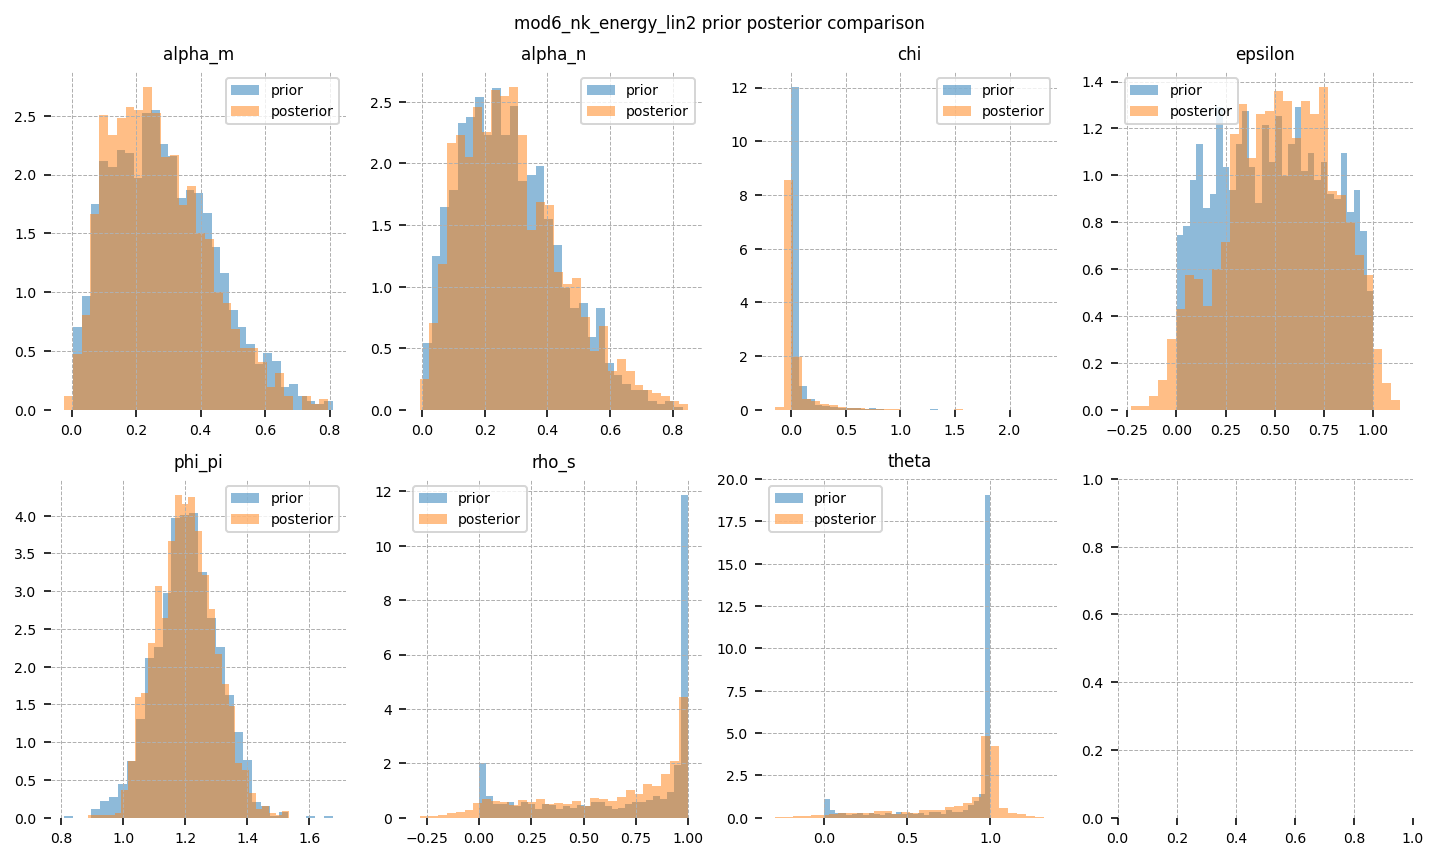

In [117]:
cols = 4
no_bins = int(len(xarr.draw)/50)

no_params = len(xarr.parameter)
rows = int(np.ceil(no_params/cols))

fig1, ax = plt.subplots(rows, cols, figsize=(5*rows, 1.5*cols))

for i in range(0, no_params):
    _ax = (int(np.floor(i/cols)), int(i%cols))
    param = xarr.parameter[i].values
    print(param)
    
    ax[_ax].hist([prior_dist[str(param)].rvs() for item in range(0, len(xarr.draw))], alpha=.5, bins=no_bins, density=True)
    ax[_ax].hist(xarr.posterior_param[:, i], alpha=.5, bins=no_bins, density=True)
    
    ax[_ax].set_title(param)
    ax[_ax].legend(['prior', 'posterior'])
    
    fig1.suptitle(f'{mod_name} prior posterior comparison')
    
# ax[rows, cols-1].hist(xarr.posterior_shock, alpha=.5, bins=no_bins, density=True)
# ax[rows, cols-1].hist([prior_dist[f'sigma_epsilon_A'].rvs() for item in range(0, len(xarr.draw))])
# ax[rows, cols-1].set_title(str(xarr.shock.values[0]))

plt.tight_layout()

In [76]:
rows

2

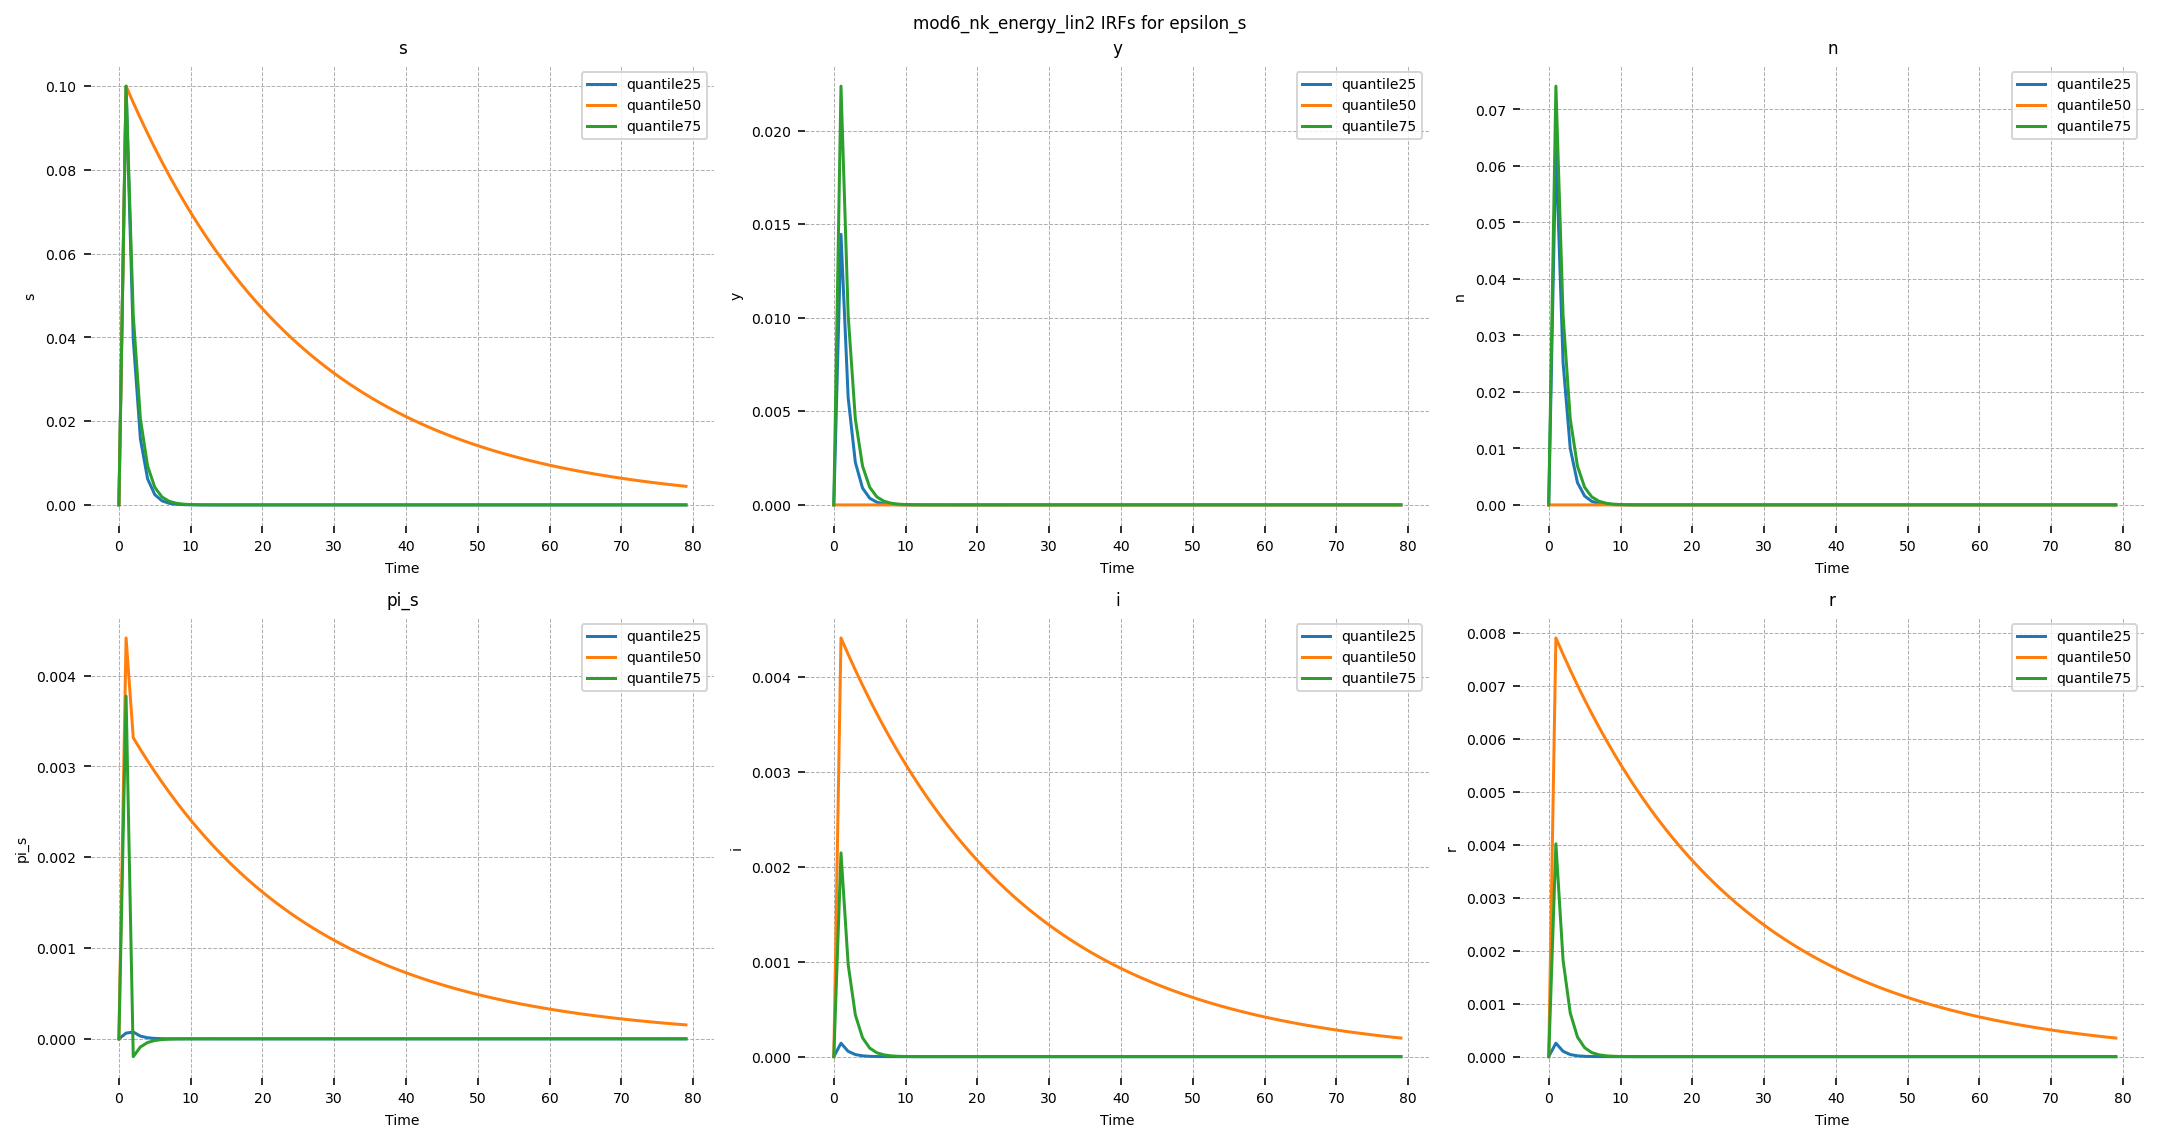

In [118]:
sim_length=80
shock_size=.1

# get quantile parameters
param_sets = [
    dict(zip(xarr.parameter.values, xarr.posterior_q1.values)),
    dict(zip(xarr.parameter.values, xarr.posterior_q2.values)),
    dict(zip(xarr.parameter.values, xarr.posterior_q3.values))
]

# get irf for each model
irfs = []
for i, params in enumerate(param_sets):
    mod.free_param_dict.update(params)
    _, mod = solve_updated_mod(mod, verbose=False, model_is_linear=mod_is_linear)
    assert _ == True
    irfs.append(mod.impulse_response_function(simulation_length=sim_length, shock_size=shock_size))
    mod.free_param_dict.update(mod_params)


# set plotting shock
for i, irf in enumerate(irfs):
    irfs[i] = irf.unstack().loc[:, shock].unstack().copy()

# plot shocks
fig2 = plot_dfs([df[mods[mod_name]['plot_vars']] for df in irfs],
         sns.lineplot,
         figsize=(15, 4),
         legend=['quantile' + str(x) for x in [25, 50, 75]],
         fig_title=f'{mod_name} IRFs for {shock}',
        )

In [119]:
# save output
fig1.savefig(os.path.join(LATEX_OUT, f'{mod_name}_posterior_hist.png'))
fig2.savefig(os.path.join(LATEX_OUT, f'{mod_name}_{shock}_irfs_quantiles.png'))